# Crop Recommendation Model Training

This notebook trains machine learning models for crop recommendation and yield prediction based on soil parameters.

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
import joblib
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
print("Libraries imported successfully!")

Libraries imported successfully!


In [7]:
# Load the dataset
try:
    df = pd.read_csv('Crop_recommendation.csv')
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")
    print("\nFirst few rows:")
    display(df.head())
except FileNotFoundError:
    print("Error: Crop_recommendation.csv file not found!")
    print("Please make sure the CSV file is in the same directory as this notebook.")

Dataset loaded successfully!
Dataset shape: (2200, 10)

Columns: ['Nitrogen', 'phosphorus', 'potassium', 'temperature', 'humidity', 'ph', 'rainfall', 'label', 'Unnamed: 8', 'Unnamed: 9']

First few rows:


,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,label,Unnamed: 8,Unnamed: 9
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,NaN,NaN
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,NaN,NaN
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,NaN,NaN
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,NaN,NaN
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,NaN,NaN


In [8]:
# Data preprocessing
# Clean column names - convert to lowercase and remove spaces
df.columns = df.columns.str.lower().str.strip()
print("Cleaned columns:", df.columns.tolist())

# Remove any unnamed columns or empty columns
df = df.drop([col for col in df.columns if 'unnamed' in col.lower() or df[col].isnull().all()], axis=1)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Handle missing values if any
if df.isnull().sum().sum() > 0:
    print("\nHandling missing values...")
    df = df.dropna()  # Remove rows with any missing values
    print(f"Dataset shape after removing missing values: {df.shape}")

print("\nFinal columns:", df.columns.tolist())
print("\nUnique crops:", df['label'].unique())
print(f"\nNumber of unique crops: {df['label'].nunique()}")

Cleaned columns: ['nitrogen', 'phosphorus', 'potassium', 'temperature', 'humidity', 'ph', 'rainfall', 'label', 'unnamed: 8', 'unnamed: 9']

Missing values:
nitrogen       0
phosphorus     0
potassium      0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Final columns: ['nitrogen', 'phosphorus', 'potassium', 'temperature', 'humidity', 'ph', 'rainfall', 'label']

Unique crops: ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']

Number of unique crops: 22


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nitrogen     2200 non-null   int64  
 1   phosphorus   2200 non-null   int64  
 2   potassium    2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None

Crop distribution:
label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cott

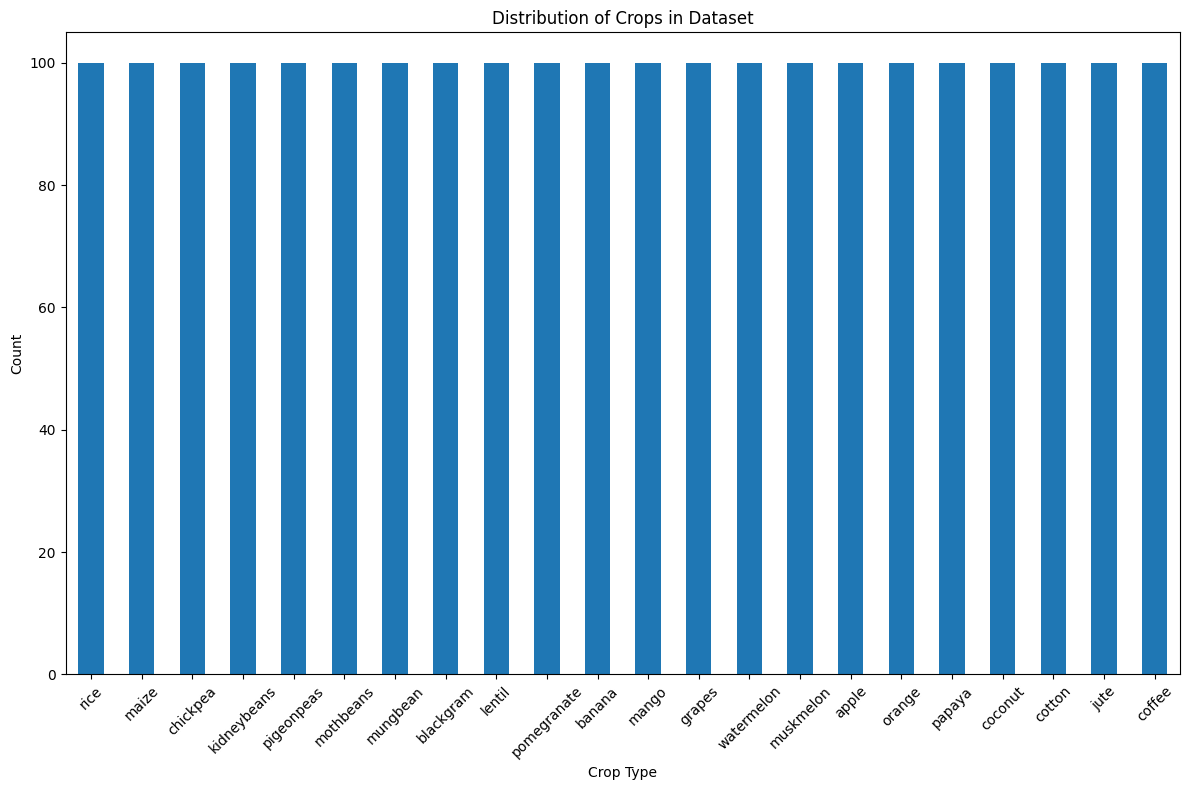

In [9]:
# Data exploration
print("Dataset Info:")
print(df.info())

print("\nCrop distribution:")
print(df['label'].value_counts())

# Visualize crop distribution
plt.figure(figsize=(12, 8))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Crops in Dataset')
plt.xlabel('Crop Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Define feature columns and target
feature_columns = ['nitrogen', 'phosphorus', 'potassium', 'temperature', 'humidity', 'ph', 'rainfall']
target_column = 'label'

# Prepare features and target
X = df[feature_columns]
y = df[target_column]

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature statistics:")
display(X.describe())

Features shape: (2200, 7)
Target shape: (2200,)

Feature statistics:


,nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


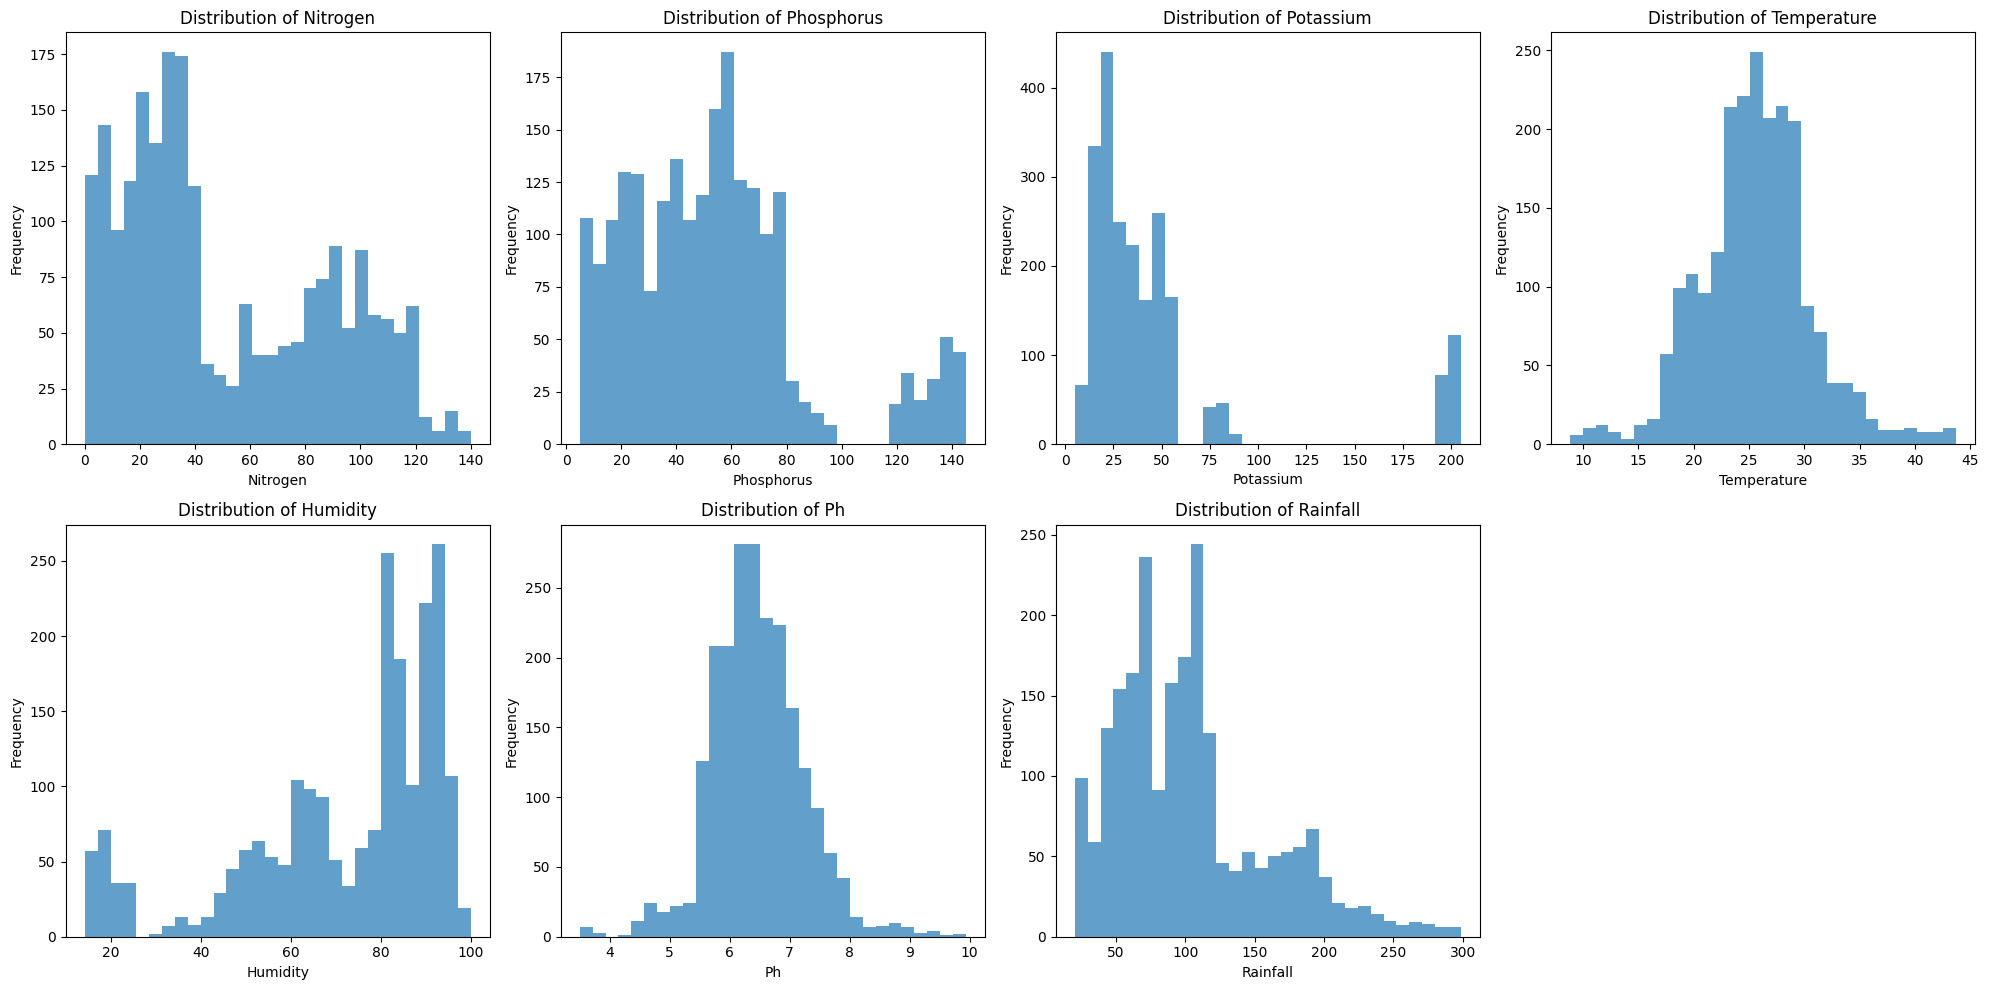

In [11]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, feature in enumerate(feature_columns):
    axes[idx].hist(X[feature], bins=30, alpha=0.7)
    axes[idx].set_title(f'Distribution of {feature.capitalize()}')
    axes[idx].set_xlabel(feature.capitalize())
    axes[idx].set_ylabel('Frequency')

# Remove the empty subplot
fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTraining set distribution:")
print(y_train.value_counts())

Training set shape: (1760, 7)
Test set shape: (440, 7)

Training set distribution:
label
orange         80
grapes         80
kidneybeans    80
mothbeans      80
cotton         80
banana         80
lentil         80
mungbean       80
coffee         80
muskmelon      80
apple          80
blackgram      80
pigeonpeas     80
maize          80
rice           80
watermelon     80
jute           80
mango          80
pomegranate    80
papaya         80
coconut        80
chickpea       80
Name: count, dtype: int64


In [13]:
# Train Random Forest Classifier for crop recommendation
print("Training Crop Recommendation Model...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nCrop Recommendation Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training Crop Recommendation Model...

Crop Recommendation Model Accuracy: 0.9955

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      

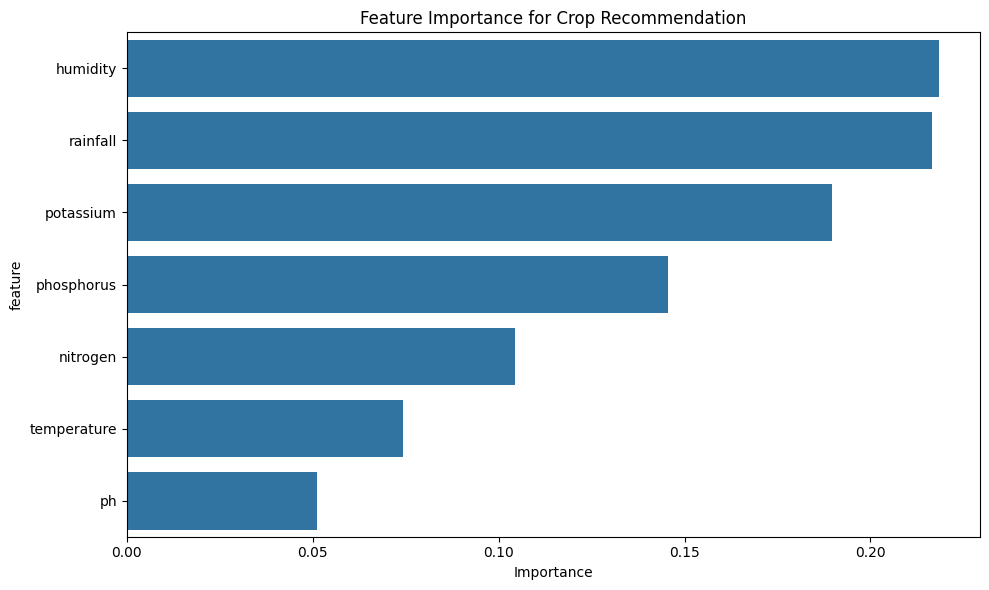

Feature Importance:


,feature,importance
4,humidity,0.218538
6,rainfall,0.216423
2,potassium,0.189566
1,phosphorus,0.145668
0,nitrogen,0.104404
3,temperature,0.074289
5,ph,0.051113


In [14]:
# Feature importance visualization
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Crop Recommendation')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Feature Importance:")
display(feature_importance)

In [15]:
# Calculate ideal ranges for each crop
print("Calculating ideal ranges for each crop...")
ideal_ranges = {}

for crop in df['label'].unique():
    crop_data = df[df['label'] == crop]
    ranges = {}
    
    for feature in feature_columns:
        ranges[feature] = {
            'min': float(crop_data[feature].min()),
            'max': float(crop_data[feature].max()),
            'mean': float(crop_data[feature].mean()),
            'std': float(crop_data[feature].std())
        }
    
    ideal_ranges[crop] = ranges

print(f"Ideal ranges calculated for {len(ideal_ranges)} crops")
print("\nSample range for rice:")
if 'rice' in ideal_ranges:
    print(json.dumps(ideal_ranges['rice'], indent=2))
else:
    # Show first available crop
    first_crop = list(ideal_ranges.keys())[0]
    print(f"Sample range for {first_crop}:")
    print(json.dumps(ideal_ranges[first_crop], indent=2))

Calculating ideal ranges for each crop...
Ideal ranges calculated for 22 crops

Sample range for rice:
{
  "nitrogen": {
    "min": 60.0,
    "max": 99.0,
    "mean": 79.89,
    "std": 11.917981491355103
  },
  "phosphorus": {
    "min": 35.0,
    "max": 60.0,
    "mean": 47.58,
    "std": 7.904965834744946
  },
  "potassium": {
    "min": 35.0,
    "max": 45.0,
    "mean": 39.87,
    "std": 2.9461668299502306
  },
  "temperature": {
    "min": 20.0454142,
    "max": 26.92995077,
    "mean": 23.6893322105,
    "std": 2.031271954371667
  },
  "humidity": {
    "min": 80.12267476,
    "max": 84.96907151,
    "mean": 82.27282153889999,
    "std": 1.418381159221309
  },
  "ph": {
    "min": 5.005306977,
    "max": 7.868474653,
    "mean": 6.425470922139999,
    "std": 0.7686920011810565
  },
  "rainfall": {
    "min": 182.5616319,
    "max": 298.5601175,
    "mean": 236.18111359399998,
    "std": 34.29182459221107
  }
}


In [16]:
# Create simulated yield data for yield prediction model
print("Creating yield data for yield prediction...")

# Yield mapping based on crop types (kg/hectare)
yield_mapping = {
    'rice': {'base': 4000, 'variance': 800},
    'maize': {'base': 5500, 'variance': 1000},
    'chickpea': {'base': 1200, 'variance': 300},
    'kidneybeans': {'base': 1800, 'variance': 400},
    'pigeonpeas': {'base': 1000, 'variance': 250},
    'mothbeans': {'base': 800, 'variance': 200},
    'mungbean': {'base': 900, 'variance': 200},
    'blackgram': {'base': 700, 'variance': 150},
    'lentil': {'base': 1100, 'variance': 250},
    'pomegranate': {'base': 15000, 'variance': 3000},
    'banana': {'base': 25000, 'variance': 5000},
    'mango': {'base': 12000, 'variance': 2500},
    'grapes': {'base': 18000, 'variance': 4000},
    'watermelon': {'base': 22000, 'variance': 4500},
    'muskmelon': {'base': 20000, 'variance': 4000},
    'apple': {'base': 16000, 'variance': 3500},
    'orange': {'base': 14000, 'variance': 3000},
    'papaya': {'base': 35000, 'variance': 7000},
    'coconut': {'base': 8000, 'variance': 1500},
    'cotton': {'base': 1500, 'variance': 400},
    'jute': {'base': 2200, 'variance': 500},
    'coffee': {'base': 1800, 'variance': 400}
}

# Create yield column based on crop type and soil parameters
np.random.seed(42)
yield_data = []

for _, row in df.iterrows():
    crop = row['label']
    if crop in yield_mapping:
        base_yield = yield_mapping[crop]['base']
        variance = yield_mapping[crop]['variance']
        
        # Add correlation with soil parameters
        factor = 1.0
        if crop in ['rice', 'maize']:  # cereals
            factor += (row['nitrogen'] - 80) * 0.002
            factor += (row['rainfall'] - 200) * 0.001
        elif crop in ['apple', 'orange', 'mango']:  # fruits
            factor += (row['temperature'] - 25) * 0.01
            factor += (row['ph'] - 6.5) * 0.05
        
        yield_value = base_yield * factor + np.random.normal(0, variance * 0.3)
        yield_data.append(max(yield_value, base_yield * 0.3))  # Ensure minimum yield
    else:
        yield_data.append(2000)  # Default yield for unknown crops

df['yield'] = yield_data
print("Yield data created successfully!")
print("\nYield statistics:")
print(df['yield'].describe())

Creating yield data for yield prediction...
Yield data created successfully!

Yield statistics:
count     2200.000000
mean      9423.969353
std       9737.558135
min        606.313177
25%       1227.065035
50%       4465.651125
75%      15792.788703
max      39558.979707
Name: yield, dtype: float64


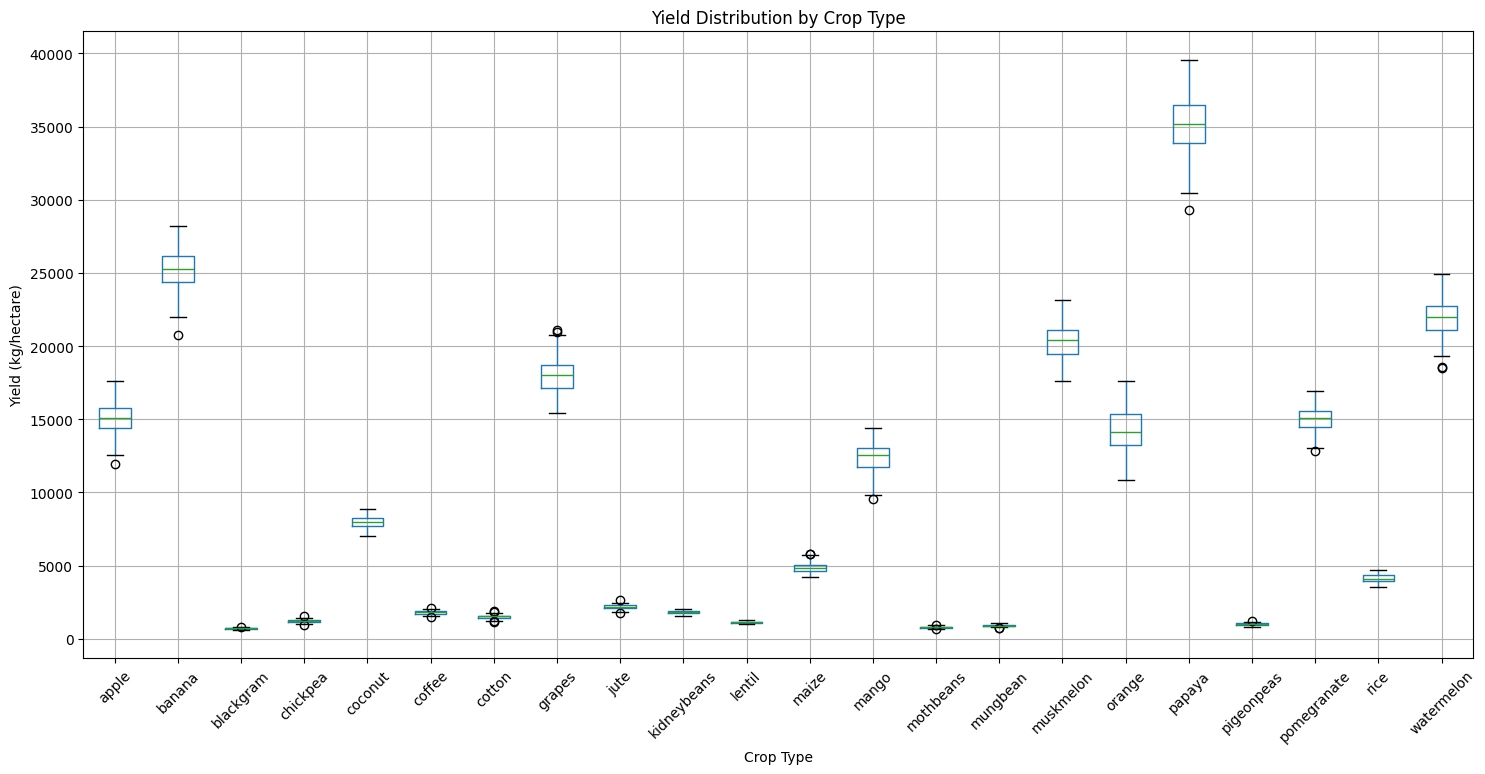

In [17]:
# Visualize yield by crop type
plt.figure(figsize=(15, 8))
df.boxplot(column='yield', by='label', ax=plt.gca())
plt.title('Yield Distribution by Crop Type')
plt.xlabel('Crop Type')
plt.ylabel('Yield (kg/hectare)')
plt.xticks(rotation=45)
plt.suptitle('')  # Remove automatic title
plt.tight_layout()
plt.show()

In [18]:
# Train yield prediction model
print("Training Yield Prediction Model...")

# Encode crop labels for yield prediction
le = LabelEncoder()
df['crop_encoded'] = le.fit_transform(df['label'])

# Features: soil parameters + crop (encoded)
X_yield = df[feature_columns + ['crop_encoded']]
y_yield = df['yield']

X_yield_train, X_yield_test, y_yield_train, y_yield_test = train_test_split(
    X_yield, y_yield, test_size=0.2, random_state=42
)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_regressor.fit(X_yield_train, y_yield_train)

# Evaluate yield model
y_yield_pred = rf_regressor.predict(X_yield_test)
yield_r2 = r2_score(y_yield_test, y_yield_pred)
yield_mse = mean_squared_error(y_yield_test, y_yield_pred)
yield_rmse = np.sqrt(yield_mse)

print(f"\nYield Prediction Model Performance:")
print(f"R² Score: {yield_r2:.4f}")
print(f"RMSE: {yield_rmse:.2f} kg/hectare")
print(f"MSE: {yield_mse:.2f}")

Training Yield Prediction Model...

Yield Prediction Model Performance:
R² Score: 0.9806
RMSE: 1384.09 kg/hectare
MSE: 1915708.06

Yield Prediction Model Performance:
R² Score: 0.9806
RMSE: 1384.09 kg/hectare
MSE: 1915708.06


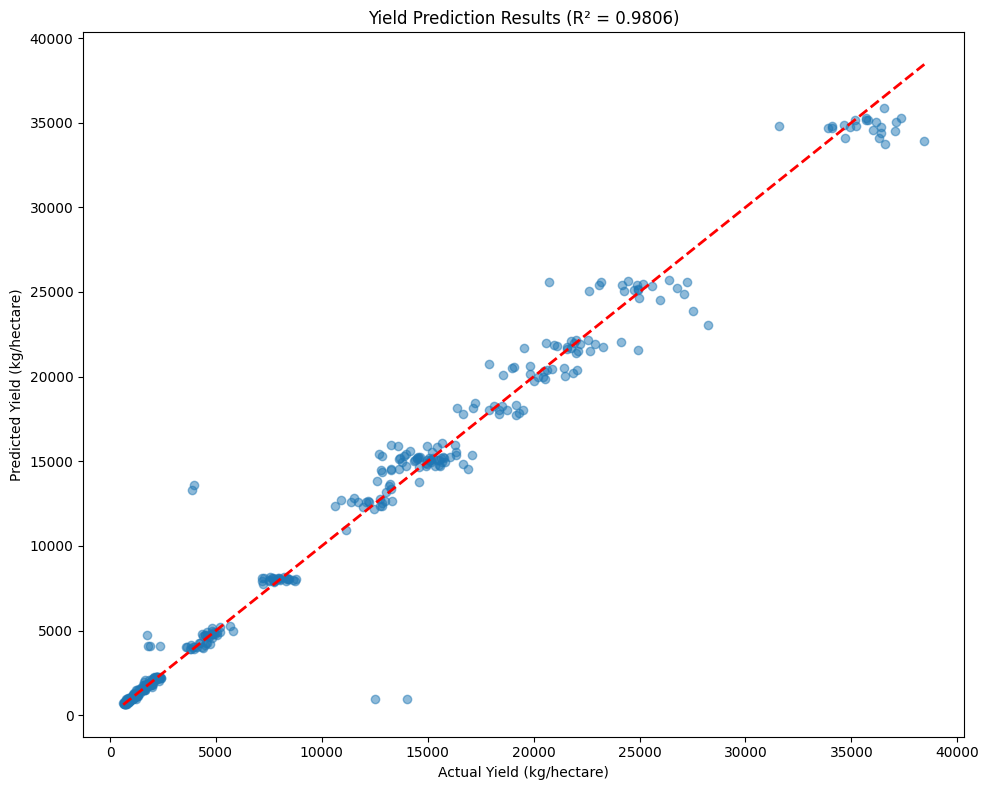

In [19]:
# Visualize yield prediction results
plt.figure(figsize=(10, 8))
plt.scatter(y_yield_test, y_yield_pred, alpha=0.5)
plt.plot([y_yield_test.min(), y_yield_test.max()], [y_yield_test.min(), y_yield_test.max()], 'r--', lw=2)
plt.xlabel('Actual Yield (kg/hectare)')
plt.ylabel('Predicted Yield (kg/hectare)')
plt.title(f'Yield Prediction Results (R² = {yield_r2:.4f})')
plt.tight_layout()
plt.show()

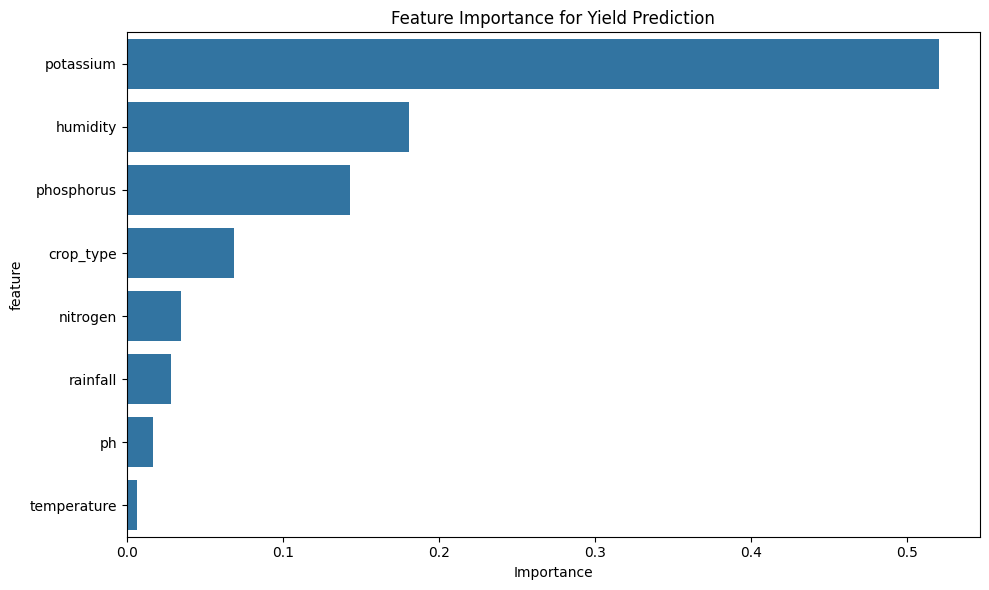

Feature Importance for Yield Prediction:


,feature,importance
2,potassium,0.520936
4,humidity,0.180878
1,phosphorus,0.143164
7,crop_type,0.068620
0,nitrogen,0.034533
6,rainfall,0.028660
5,ph,0.016727
3,temperature,0.006482


In [20]:
# Feature importance for yield prediction
yield_feature_importance = pd.DataFrame({
    'feature': feature_columns + ['crop_type'],
    'importance': rf_regressor.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=yield_feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Yield Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Feature Importance for Yield Prediction:")
display(yield_feature_importance)

In [21]:
# Save models and data
print("Saving models and data...")

try:
    # Save models
    joblib.dump(rf_classifier, 'crop_model.pkl')
    joblib.dump(rf_regressor, 'yield_model.pkl')
    joblib.dump(le, 'label_encoder.pkl')
    
    # Save ideal ranges
    with open('ideal_ranges.json', 'w') as f:
        json.dump(ideal_ranges, f, indent=2)
    
    print("\n✅ Models and data saved successfully!")
    print("\nFiles created:")
    print("- crop_model.pkl (Crop recommendation model)")
    print("- yield_model.pkl (Yield prediction model)")
    print("- label_encoder.pkl (Label encoder for crops)")
    print("- ideal_ranges.json (Ideal parameter ranges for each crop)")
    
except Exception as e:
    print(f"❌ Error saving files: {e}")

Saving models and data...

✅ Models and data saved successfully!

Files created:
- crop_model.pkl (Crop recommendation model)
- yield_model.pkl (Yield prediction model)
- label_encoder.pkl (Label encoder for crops)
- ideal_ranges.json (Ideal parameter ranges for each crop)


In [22]:
# Test the models with sample predictions
print("Testing models with sample predictions...")

# Sample soil parameters
sample_data = pd.DataFrame({
    'nitrogen': [90, 20, 40],
    'phosphorus': [42, 80, 60],
    'potassium': [43, 25, 40],
    'temperature': [20.9, 25.0, 30.0],
    'humidity': [82.0, 80.0, 75.0],
    'ph': [6.5, 7.0, 6.8],
    'rainfall': [200, 150, 180]
})

# Predict crops
predicted_crops = rf_classifier.predict(sample_data)
crop_probabilities = rf_classifier.predict_proba(sample_data)

print("\nCrop Predictions:")
for i, (crop, probs) in enumerate(zip(predicted_crops, crop_probabilities)):
    top_3_indices = np.argsort(probs)[::-1][:3]
    top_3_crops = [rf_classifier.classes_[idx] for idx in top_3_indices]
    top_3_probs = [probs[idx] for idx in top_3_indices]
    
    print(f"\nSample {i+1}:")
    print(f"  Predicted crop: {crop}")
    print(f"  Top 3 recommendations:")
    for j, (c, p) in enumerate(zip(top_3_crops, top_3_probs)):
        print(f"    {j+1}. {c}: {p:.3f}")

# Predict yields for the predicted crops
print("\nYield Predictions:")
for i, crop in enumerate(predicted_crops):
    crop_encoded = le.transform([crop])[0]
    yield_features = np.concatenate([sample_data.iloc[i].values, [crop_encoded]])
    predicted_yield = rf_regressor.predict([yield_features])[0]
    print(f"Sample {i+1} ({crop}): {predicted_yield:.2f} kg/hectare")

Testing models with sample predictions...

Crop Predictions:

Sample 1:
  Predicted crop: rice
  Top 3 recommendations:
    1. rice: 0.871
    2. jute: 0.125
    3. papaya: 0.002

Sample 2:
  Predicted crop: pigeonpeas
  Top 3 recommendations:
    1. pigeonpeas: 0.286
    2. papaya: 0.127
    3. blackgram: 0.082

Sample 3:
  Predicted crop: papaya
  Top 3 recommendations:
    1. papaya: 0.484
    2. jute: 0.148
    3. mungbean: 0.082

Yield Predictions:
Sample 1 (rice): 4188.70 kg/hectare
Sample 2 (pigeonpeas): 986.19 kg/hectare
Sample 3 (papaya): 8183.97 kg/hectare


In [23]:
# Model summary
print("="*60)
print("MODEL TRAINING SUMMARY")
print("="*60)
print(f"Dataset: {df.shape[0]} samples, {len(feature_columns)} features")
print(f"Number of crops: {df['label'].nunique()}")
print(f"\nCrop Recommendation Model:")
print(f"  - Algorithm: Random Forest Classifier")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - Training samples: {X_train.shape[0]}")
print(f"  - Test samples: {X_test.shape[0]}")
print(f"\nYield Prediction Model:")
print(f"  - Algorithm: Random Forest Regressor")
print(f"  - R² Score: {yield_r2:.4f}")
print(f"  - RMSE: {yield_rmse:.2f} kg/hectare")
print(f"\nFiles saved:")
print(f"  - crop_model.pkl")
print(f"  - yield_model.pkl")
print(f"  - label_encoder.pkl")
print(f"  - ideal_ranges.json")
print("="*60)
print("✅ Model training completed successfully!")
print("You can now run the Flask API using app.py")
print("="*60)

MODEL TRAINING SUMMARY
Dataset: 2200 samples, 7 features
Number of crops: 22

Crop Recommendation Model:
  - Algorithm: Random Forest Classifier
  - Accuracy: 0.9955
  - Training samples: 1760
  - Test samples: 440

Yield Prediction Model:
  - Algorithm: Random Forest Regressor
  - R² Score: 0.9806
  - RMSE: 1384.09 kg/hectare

Files saved:
  - crop_model.pkl
  - yield_model.pkl
  - label_encoder.pkl
  - ideal_ranges.json
✅ Model training completed successfully!
You can now run the Flask API using app.py
